## Imports

In [13]:
try:
    from pathlib import Path
    import pandas as pd
    import matplotlib.pyplot as plt
    from lib.lib_utils import Utils
    import seaborn as sns
    from lib.lib_defect_analysis import Features
    from tqdm import tqdm
    
except Exception as e:
    print(f"Some module are missing: {e}\n")

data_path = Path().resolve().joinpath("data")
xyz_files_path = data_path.joinpath("xyz_files")
yolo_model_path = data_path.joinpath("models","best_100_campioni_new.pt")
images_path = data_path.joinpath("images")
crops_path = data_path.joinpath("crops")

plt.style.use("dark_background")

## Generate images from xyz files

In [14]:
Utils.from_xyz_to_png(
    xyz_files_path, 
    images_path)

100%|██████████| 4272/4272 [02:55<00:00, 24.30it/s]


## YOLO inference to generate binary crops

In [ ]:
Utils.generate_yolo_crops(
    images_path,
    crops_path,
    yolo_model_path,
    binary_mask=True,
)

## Features extraction and dataframe generation

In [16]:

images = [
    f for f in crops_path.iterdir() if f.suffix.lower() in Features.IMAGE_EXTENSIONS
]

features = {}

for image in tqdm(images):
    if len(features) == 0:
        keys_list = list(features.keys())
        df = pd.DataFrame(columns=keys_list)
    else:
        features.clear()

    name = image.stem.split("_crop")[0]

    with open(str(xyz_files_path.joinpath(f"{name}.xyz")), "r") as file:
        first_line = file.readline()
    n_atoms = int(first_line.strip())

    features.update({"file_name": name})
    features.update({"n_atoms": n_atoms})

    shape_features = Features.extract_shape_features(image, grayscale=True)
    if shape_features is not None:
        features.update(shape_features)

    new_row = pd.Series(features)
    df = pd.concat([df, new_row.to_frame().T], ignore_index=True)

grouped_df = df.groupby("file_name").agg(
    {
        "n_atoms": "first",
        "area": "sum",
        "num_pixels": "sum",
        "perimeter": "sum",
        "circularity": lambda x: (x * df.loc[x.index, "area"]).sum() / df.loc[x.index, "area"].sum(),
        "solidity": lambda x: (x * df.loc[x.index, "area"]).sum() / df.loc[x.index, "area"].sum(),
        "compactness": lambda x: (x * df.loc[x.index, "area"]).sum() / df.loc[x.index, "area"].sum(),
        "feret_diameter": lambda x: (x * df.loc[x.index, "area"]).sum() / df.loc[x.index, "area"].sum(),
        "eccentricity": lambda x: (x * df.loc[x.index, "area"]).sum() / df.loc[x.index, "area"].sum(),
    }
).reset_index()

original_df = pd.read_csv(
    xyz_files_path.joinpath("dataset_graphene.csv")
)

energy_dict = original_df.set_index("file_name")["total_energy"].to_dict()

# Aggiunta della colonna total_energy al primo dataframe
grouped_df["total_energy"] = grouped_df["file_name"].map(energy_dict)
grouped_df["energy_per_atom"] = grouped_df["total_energy"] / grouped_df["n_atoms"]

grouped_df.to_csv(
    data_path.joinpath("features.csv"), index=False
)

  3%|▎         | 193/7038 [00:00<00:03, 1923.17it/s]

100%|██████████| 7038/7038 [00:04<00:00, 1611.05it/s]


## Plot correlations

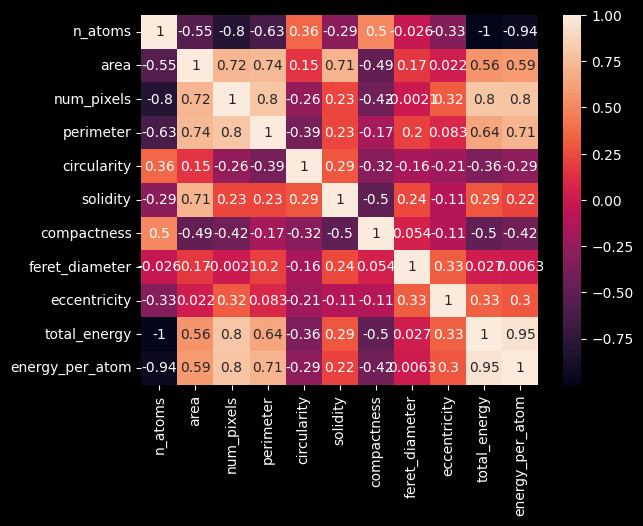

In [17]:
grouped_df = pd.read_csv(data_path.joinpath("features.csv"))
columns_to_drop =["file_name"]
merged_df = grouped_df.drop(columns_to_drop, axis=1)

# stampo heatmap 
corr = merged_df.corr()
sns.heatmap(corr, annot=True)

# stampo basic correlogram
#sns.pairplot(merged_df)
plt.show()

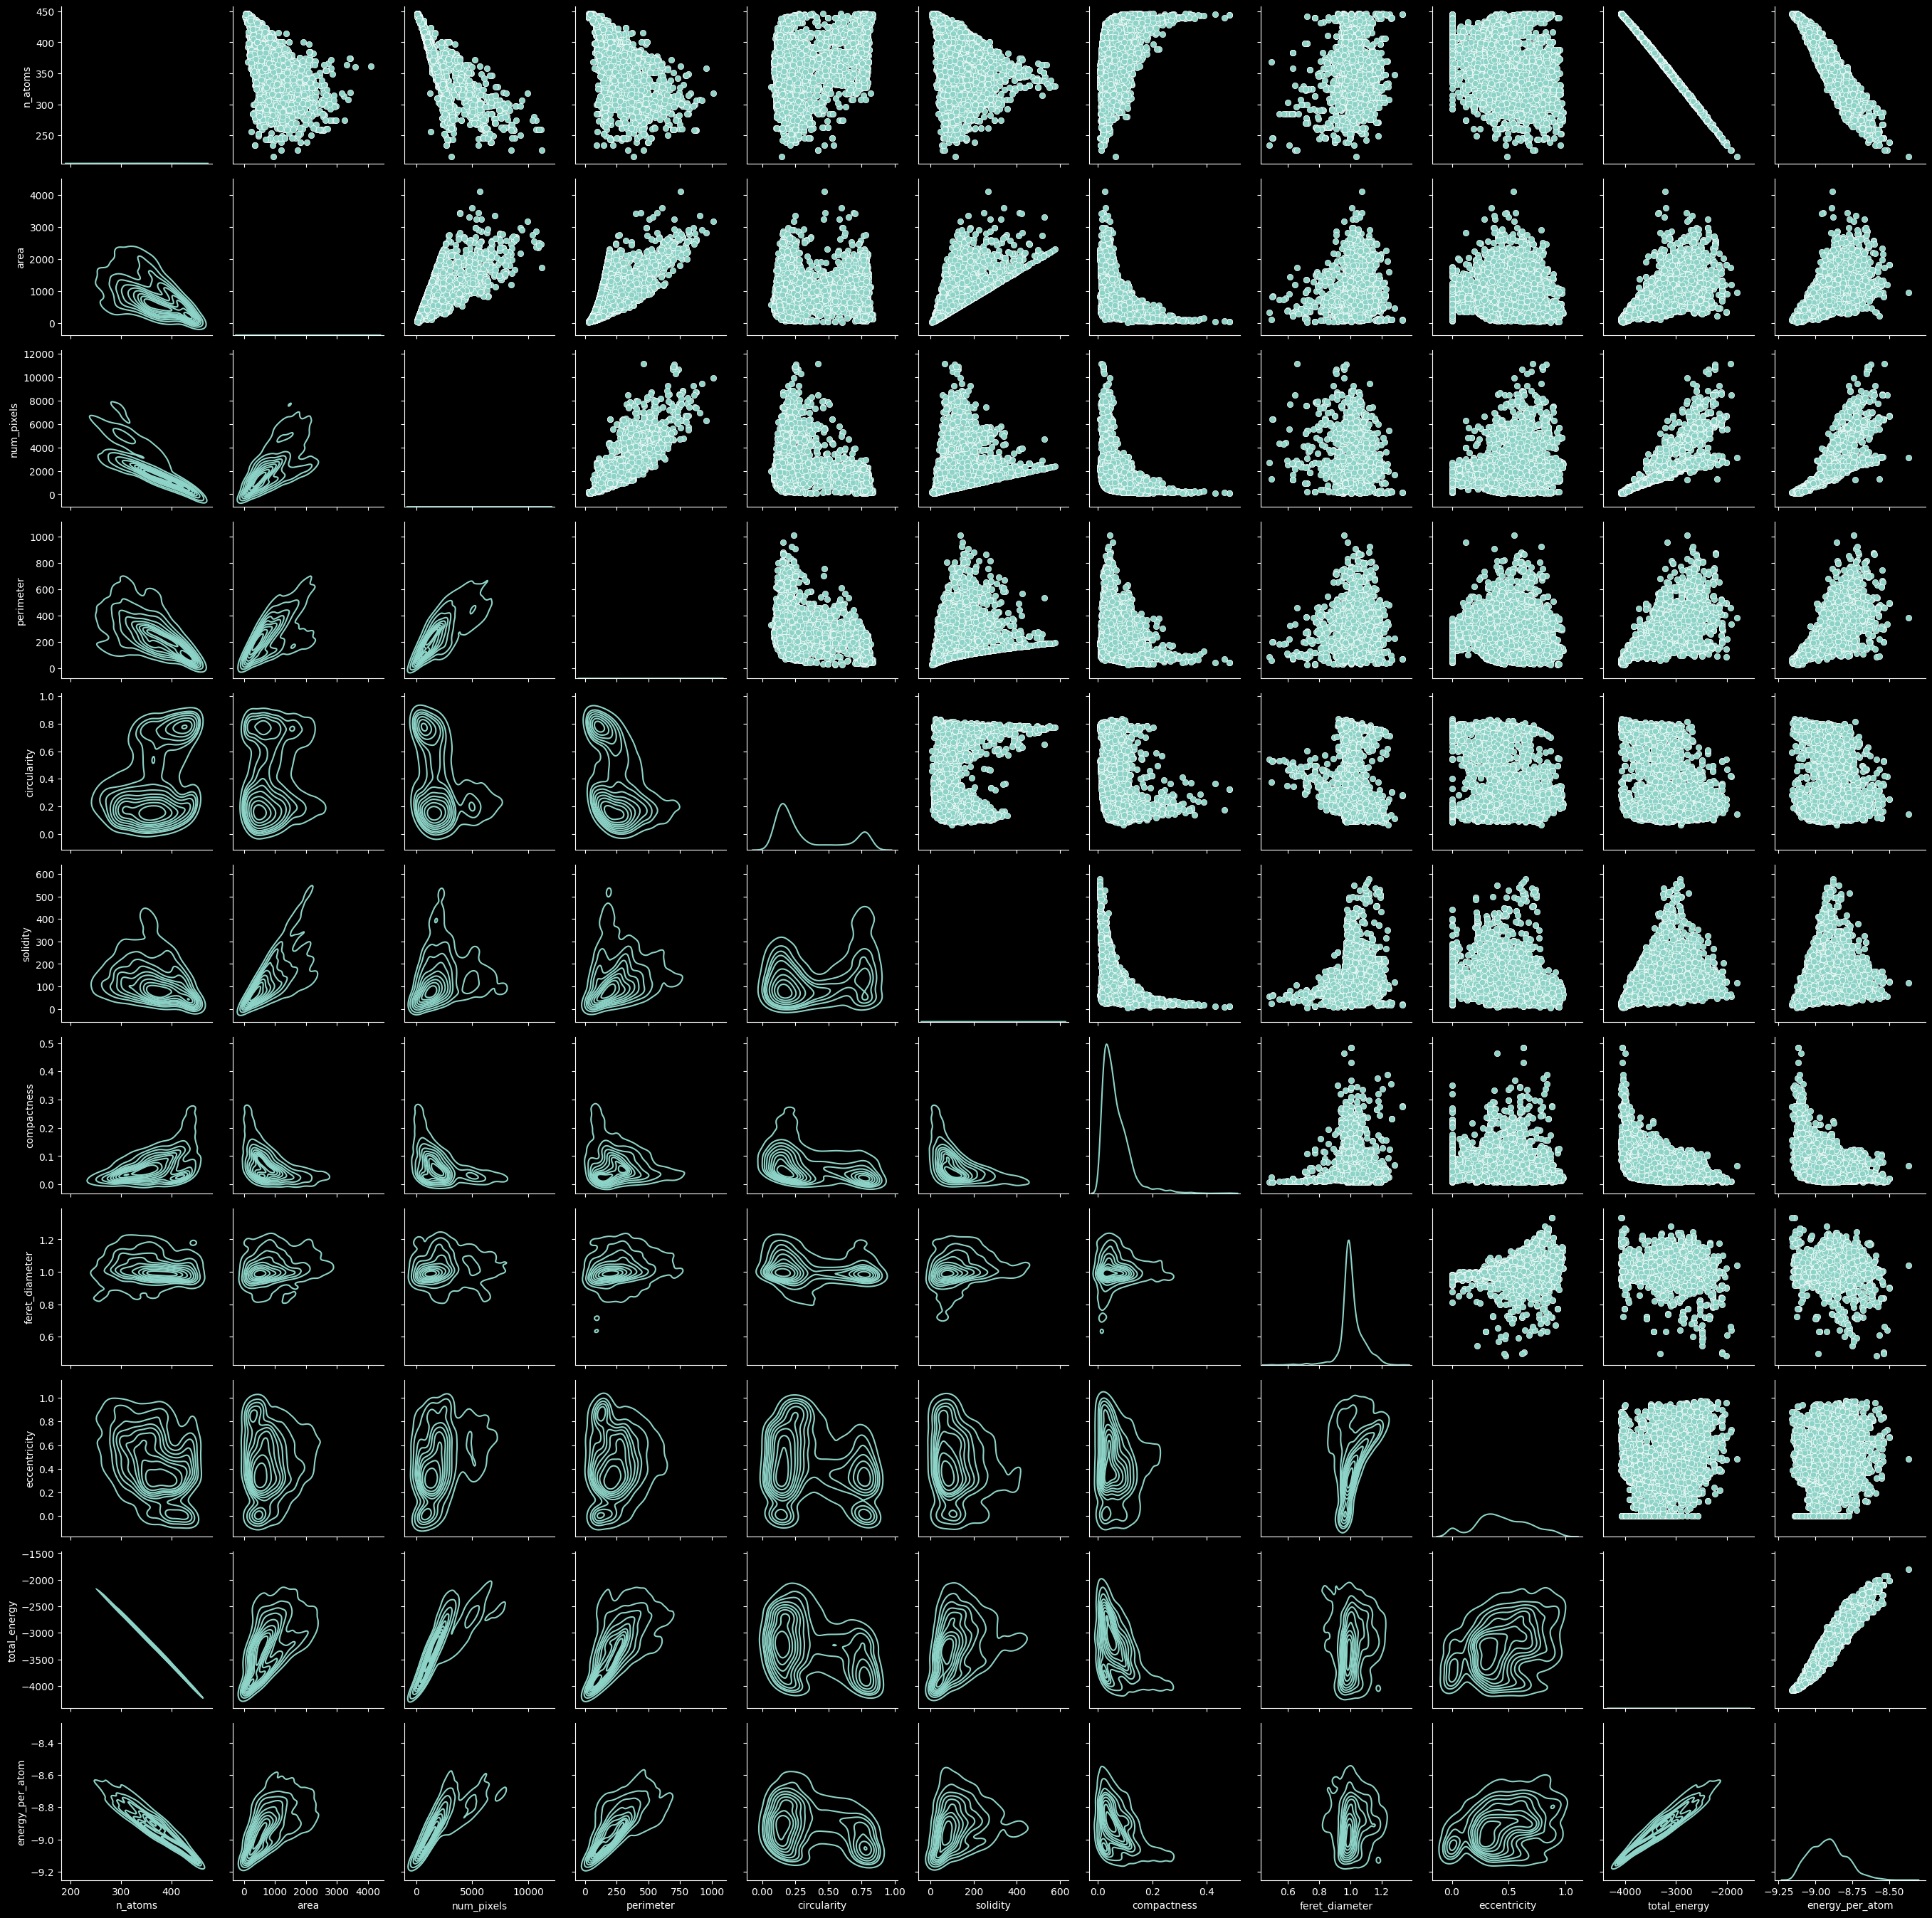

In [18]:
g = sns.PairGrid(grouped_df)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)

## Total energy prediction

In [19]:
try:
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn import ensemble
    from sklearn.inspection import permutation_importance
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler
    import scipy
    
except Exception as e:
    print(f"Some module are missing: {e}\n")

## Data preparation

In [20]:

features_list = [ "area","perimeter", "circularity", "solidity", "compactness", "feret_diameter", "eccentricity"]

X = grouped_df[features_list].values

y = grouped_df["total_energy"].values.flatten() #array con tutti i valori raget total_energy

scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

scaler2 = MinMaxScaler()
y_norm = scaler2.fit_transform(y.reshape(-1, 1))

## Split dataset and set hyperparameters

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y_norm, test_size=0.1, random_state=13
)

params = {
    "n_estimators": 1000,
    "max_depth": 20,
    "min_samples_split": 10,
    "learning_rate": 0.005,
    "loss": "squared_error",
}

## Set regressor and loss function

In [28]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

/home/tommaso/miniconda3/envs/yolo/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


The mean squared error (MSE) on test set: 0.0045


## Deviance

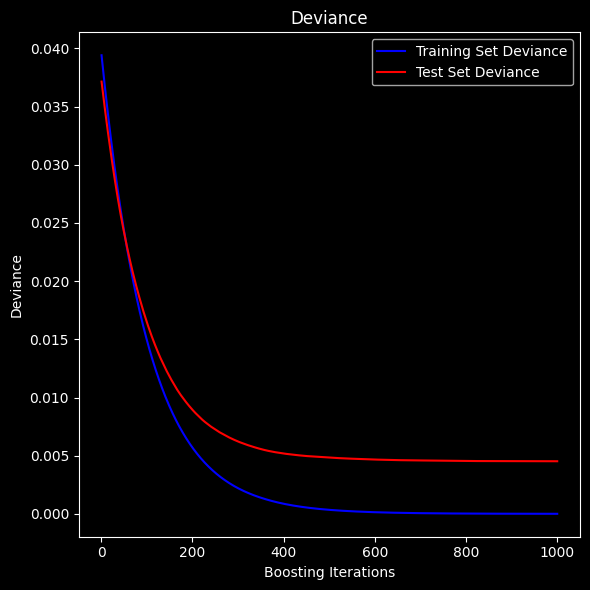

In [29]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

## Features importance

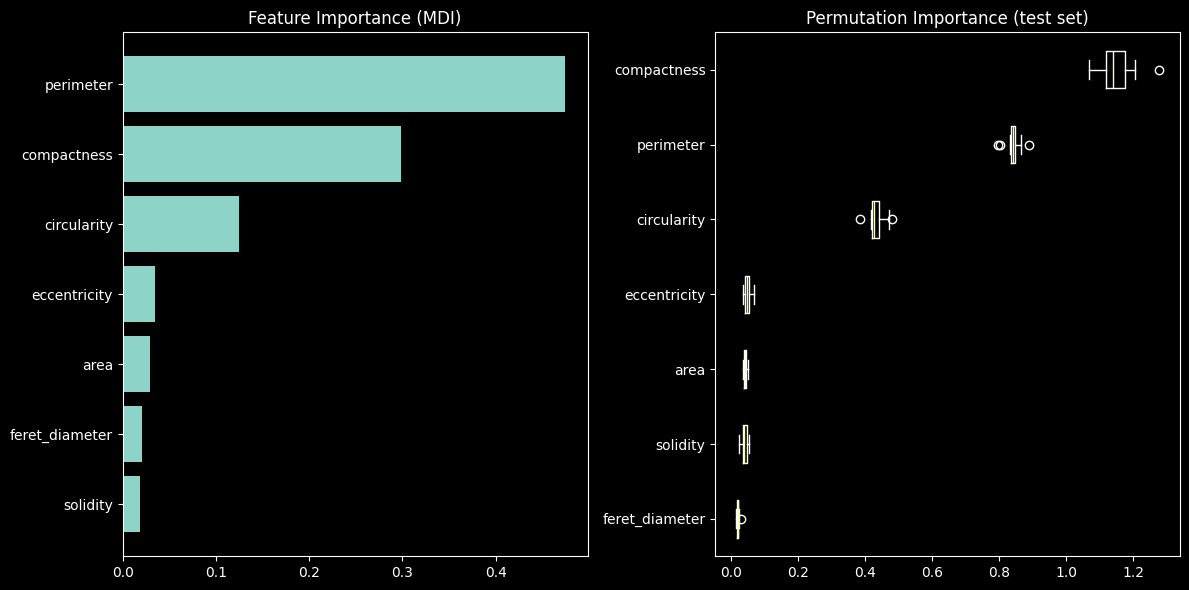

In [30]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features_list)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(features_list)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()  
plt.show()

## Fit curve

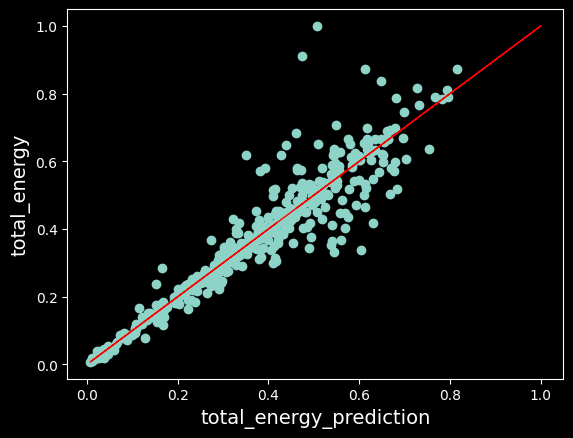

In [31]:
plt.scatter(y_pred, y_test)
plt.plot(y_test, y_test,  color='red', linewidth=1)

plt.xlabel("total_energy_prediction", fontsize=14)
plt.ylabel("total_energy", fontsize = 14)
plt.show()

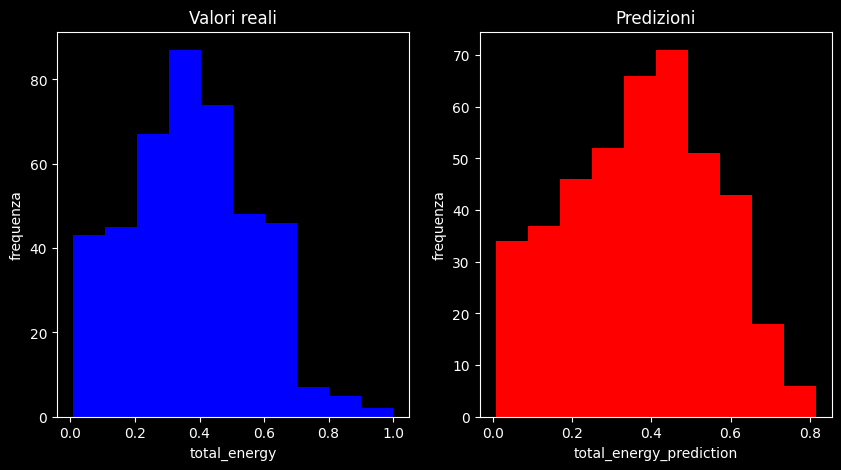

In [32]:
# Crea la figura e i due assi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Istogramma 1
# ax1.hist(y_test, bins=5, weights=y_test, color='blue')
ax1.hist(y_test, bins=10, color='blue')

ax1.set_xlabel('total_energy')
ax1.set_ylabel('frequenza')
ax1.set_title('Valori reali')

# Istogramma 2
# ax2.hist(y_pred, bins=5, weights=y_pred, color='red')
ax2.hist(y_pred, bins=10, color='red')
ax2.set_xlabel('total_energy_prediction')
ax2.set_ylabel('frequenza')
ax2.set_title('Predizioni')

# Mostra il grafico
plt.show()

In [33]:
res = scipy.stats.ttest_ind(y_test, y_pred, equal_var=True)

display(res)

TtestResult(statistic=array([   -0.27634,      1.8719,      1.7594,     0.22327,       1.168,   -0.084675,    -0.89267,     0.80566,      0.7137,    -0.47355,  -0.0063911,      1.7282,      1.6864,      1.4149,      0.2604,      -0.402,     0.15097,    -0.77686,       1.014,    -0.68285,    -0.71891,     -1.3049,     -1.0913,    -0.94441,
            1.0476,      1.4948,     0.36291,       1.729,    -0.39468,     -2.2798,    -0.41205,     -1.2568,    -0.36783,       1.364,    -0.88979,     0.75401,     -0.5336,      1.0839,     -1.6023,     0.89528,      1.5106,    -0.25199,    -0.95529,      1.3053,     0.93224,      0.6674,      1.1727,     -0.1328,
           0.59802,    0.014003,    0.050681,      -1.165,     -1.5611,    0.093694,     -1.3025,     -1.3891,    -0.18994,     -1.6947,     -1.2593,    -0.89698,     0.71645,    -0.62119,    -0.73079,    -0.81538,    -0.46082,    -0.85125,     0.47901,    0.048787,     -1.4175,    -0.21045,      -0.374,     -1.4105,
            1.4758,  

## Predictions - Real Target Values

In [34]:
print("Target total_energy: ")
print(y_test[1:10])
print("Predicted total_energy: ")
print(reg.predict(X_test[1:10]))
print("Error: ")
print(y_test[1:10]-reg.predict(X_test[1:10]))

Target total_energy: 
[[   0.017859]
 [     0.0301]
 [    0.31676]
 [    0.14653]
 [    0.41029]
 [    0.52029]
 [    0.20852]
 [    0.22827]
 [    0.45097]]
Predicted total_energy: 
[   0.010595    0.032415     0.33027     0.14709     0.38998     0.54664     0.21734     0.23517     0.46538]
Error: 
[[  0.0072642   -0.014556    -0.31241    -0.12923    -0.37212    -0.52878    -0.19948    -0.21731    -0.44752]
 [   0.019505  -0.0023149    -0.30017    -0.11699    -0.35988    -0.51654    -0.18724    -0.20507    -0.43528]
 [    0.30617     0.28435   -0.013503     0.16967   -0.073214    -0.22988     0.09942     0.08159    -0.14861]
 [    0.13594     0.11412    -0.18374 -0.00055975    -0.24345    -0.40011   -0.070812   -0.088643    -0.31885]
 [     0.3997     0.37788    0.080026      0.2632    0.020316    -0.13635     0.19295     0.17512   -0.055085]
 [    0.50969     0.48787     0.19002      0.3732     0.13031   -0.026357     0.30294     0.28511    0.054908]
 [    0.19793     0.17611    -0.1

## R^2 Score

In [35]:
reg.score(X_test, y_test)

0.8790933085138475